# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

The success in **opening a new branch** is often determined by its location. A **suitable location** allows to acquire higher profits and thus it allows **further expansion of the brand**. For this reason, this project will try to find the **optimal location** to open a **new cafeteria** in a neighborhood in the city of Toronto.

Since there are many coffee shops in Toronto, attempts will be made to identify locations that contain **few coffee shops** and whose **rating is low**, in order to open a cafeteria with better features to be able to capture the largest number of customers.

To carry out this project, cluster techniques will be used, such as the algorithm of k-means and descriptive statistics on the information that will be detailed below. In addition, we will assume that there is a cafeteria with good income in the **Wychwood Park neighborhood**, so the **optimal location should be similar to that neighborhood**. This project may be of great interest to big coffee food industries such as: **Starbucks**.

## Data <a name="data"></a>

Based on the problem definition, the factors that will influence the determination of the optimal location are:
* Number of coffee shops, restaurants, schools, etc in neighborhoods (all available business).
* Ratings of coffee shops in neighborhoods. 
* Sociodemographic information of the neighborhoods.

The following data sources will be needed to extract/generate the required information:
* The list of existing neighborhoods in the city of Toronto will be obtained from the **Neighborhood Profiles** from the link https://www.toronto.ca/. In addition, this database contains population and population density information that will be used in the analysis.
* The coordinates of the neighborhood centers of the city of Toronto will be obtained using the **geopy library** to obtain the latitude and longitude of the corresponding coordinates.
* The number of restaurants, coffee shops, educational centers, etc; with their respective location in each neighborhood and rating for available coffee shops will be obtained using the **Foursquare API**.

### Load and filter important information from Neighbourhood Profiles

Let's load dataset of Neighborhood Profiles from Toronto City. After let's show a header

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

df_profiles = pd.read_csv('https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv',
                          encoding='latin-1')
df_profiles.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,...,37,7,137,64,60,94,100,97,27,31
1,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%



We're going to extract the needed information needed for clustering. In this case, we select only the following information:

* Population, 2016
* Population density per square kilometre
* Youth (15-24 years)
* Working Age (25-54 years)
* Pre-retirement (55-64 years)
* Management occupations
* Business, finance and administration occupations
* Health occupations
* Occupations in education, law and social, community and government services
* Occupations in manufacturing and utilities
* Total income: Population with an amount

In [2]:
df_SocioDemo = pd.concat([
    df_profiles[df_profiles["Characteristic"]=='Population, 2016'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='Population density per square kilometre'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='Youth (15-24 years)'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='Working Age (25-54 years)'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='Pre-retirement (55-64 years)'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='    0 Management occupations'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='    1 Business, finance and administration occupations'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='    3 Health occupations'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='    4 Occupations in education, law and social, community and government services'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='    9 Occupations in manufacturing and utilities'].iloc[0,5:],
    df_profiles[df_profiles["Characteristic"]=='Total income: Population with an amount'].iloc[0,5:]
], axis=1)

df_SocioDemo.columns = ['POPULATION_2016', 'POPULATION_DENSITY', 'YOUTH_PEOPLE', 'WORKING_PEOPLE', 'PRERETIREMENT_PEOPLE', 
                       'MANAGEMENT_OCCUPATION', 'BUSINESS_OCCUPATION', 'HEALTH_OCCUPATION', 'EDUCATION_OCCUPATION', 
                       'MANUFACTURING__OCCUPATION', 'INCOME']
df_SocioDemo.head()

,POPULATION_2016,POPULATION_DENSITY,YOUTH_PEOPLE,WORKING_PEOPLE,PRERETIREMENT_PEOPLE,MANAGEMENT_OCCUPATION,BUSINESS_OCCUPATION,HEALTH_OCCUPATION,EDUCATION_OCCUPATION,MANUFACTURING__OCCUPATION,INCOME
Agincourt North,"29,113","3,929","3,705","11,305","4,230",960,"2,425",740,950,"1,350","23,505"
Agincourt South-Malvern West,"23,757","3,034","3,360","9,965","3,265",960,"2,170",655,865,"1,015","19,370"
Alderwood,"12,054","2,435","1,235","5,220","1,825",840,"1,150",295,735,350,"9,915"
Annex,"30,526","10,863","3,750","15,040","3,480","2,645","3,410","1,020","3,955",120,"25,615"
Banbury-Don Mills,"27,695","2,775","2,730","10,810","3,555","2,120","2,870","1,145","1,875",165,"22,335"


We're going to change to right object type for model.

In [3]:
print(' *** Object Type before *** ')
print(df_SocioDemo.dtypes)
for col in df_SocioDemo.columns:
    df_SocioDemo[col] = df_SocioDemo[col].str.replace(',','.').astype(float)
    
print('\n *** Object Type after *** ')
print(df_SocioDemo.dtypes)

 *** Object Type before *** 
POPULATION_2016              object
POPULATION_DENSITY           object
YOUTH_PEOPLE                 object
WORKING_PEOPLE               object
PRERETIREMENT_PEOPLE         object
MANAGEMENT_OCCUPATION        object
BUSINESS_OCCUPATION          object
HEALTH_OCCUPATION            object
EDUCATION_OCCUPATION         object
MANUFACTURING__OCCUPATION    object
INCOME                       object
dtype: object

 *** Object Type after *** 
POPULATION_2016              float64
POPULATION_DENSITY           float64
YOUTH_PEOPLE                 float64
WORKING_PEOPLE               float64
PRERETIREMENT_PEOPLE         float64
MANAGEMENT_OCCUPATION        float64
BUSINESS_OCCUPATION          float64
HEALTH_OCCUPATION            float64
EDUCATION_OCCUPATION         float64
MANUFACTURING__OCCUPATION    float64
INCOME                       float64
dtype: object


,POPULATION_2016,POPULATION_DENSITY,YOUTH_PEOPLE,WORKING_PEOPLE,PRERETIREMENT_PEOPLE,MANAGEMENT_OCCUPATION,BUSINESS_OCCUPATION,HEALTH_OCCUPATION,EDUCATION_OCCUPATION,MANUFACTURING__OCCUPATION,INCOME
Agincourt North,29.113,3.929,3.705,11.305,4.230,960.000,2.425,740.000,950.000,1.350,23.505
Agincourt South-Malvern West,23.757,3.034,3.360,9.965,3.265,960.000,2.170,655.000,865.000,1.015,19.370
Alderwood,12.054,2.435,1.235,5.220,1.825,840.000,1.150,295.000,735.000,350.000,9.915
Annex,30.526,10.863,3.750,15.040,3.480,2.645,3.410,1.020,3.955,120.000,25.615
Banbury-Don Mills,27.695,2.775,2.730,10.810,3.555,2.120,2.870,1.145,1.875,165.000,22.335


### Neighborhood Candidates

Now, we're going to get the geographic location of the Neighbourhood, ie, the longitude and latitude of each neighborhood. Then we're going to merge to *df_SocioDemo* data set.

In [29]:
#!pip install geopy
from geopy.geocoders import Nominatim

latitude = []
longitude = []
for neigh in df_SocioDemo.index:
    address = neigh + ', Canada'
    print(address)
    try:
        location = None
        ind = 0
        while(location is None):
            geolocator = Nominatim(user_agent="toronto_explorer")
            location = geolocator.geocode(address)
            ind += 1
            lat = location.latitude
            lon = location.longitude
            if ind>3:
                lat = np.nan
                lon = np.nan
                break
        latitude.append(lat)
        longitude.append(lon)
    except:
        latitude.append(np.nan)
        longitude.append(np.nan)

Agincourt North, Canada
Agincourt South-Malvern West, Canada
Alderwood, Canada
Annex, Canada
Banbury-Don Mills, Canada
Bathurst Manor, Canada
Bay Street Corridor, Canada
Bayview Village, Canada
Bayview Woods-Steeles, Canada
Bedford Park-Nortown, Canada
Beechborough-Greenbrook, Canada
Bendale, Canada
Birchcliffe-Cliffside, Canada
Black Creek, Canada
Blake-Jones, Canada
Briar Hill-Belgravia, Canada
Bridle Path-Sunnybrook-York Mills, Canada
Broadview North, Canada
Brookhaven-Amesbury, Canada
Cabbagetown-South St. James Town, Canada
Caledonia-Fairbank, Canada
Casa Loma, Canada
Centennial Scarborough, Canada
Church-Yonge Corridor, Canada
Clairlea-Birchmount, Canada
Clanton Park, Canada
Cliffcrest, Canada
Corso Italia-Davenport, Canada
Danforth, Canada
Danforth East York, Canada
Don Valley Village, Canada
Dorset Park, Canada
Dovercourt-Wallace Emerson-Junction, Canada
Downsview-Roding-CFB, Canada
Dufferin Grove, Canada
East End-Danforth, Canada
Edenbridge-Humber Valley, Canada
Eglinton East,

In [30]:
df_SocioDemo['LATITUDE'] = latitude
df_SocioDemo['LONGITUDE'] = longitude

df_SocioDemo.head()

,POPULATION_2016,POPULATION_DENSITY,YOUTH_PEOPLE,WORKING_PEOPLE,PRERETIREMENT_PEOPLE,MANAGEMENT_OCCUPATION,BUSINESS_OCCUPATION,HEALTH_OCCUPATION,EDUCATION_OCCUPATION,MANUFACTURING__OCCUPATION,INCOME,LATITUDE,LONGITUDE
Agincourt North,29.113,3.929,3.705,11.305,4.230,960.000,2.425,740.000,950.000,1.350,23.505,43.808038,-79.266439
Agincourt South-Malvern West,23.757,3.034,3.360,9.965,3.265,960.000,2.170,655.000,865.000,1.015,19.370,43.798529,-79.262250
Alderwood,12.054,2.435,1.235,5.220,1.825,840.000,1.150,295.000,735.000,350.000,9.915,43.601717,-79.545232
Annex,30.526,10.863,3.750,15.040,3.480,2.645,3.410,1.020,3.955,120.000,25.615,43.670338,-79.407117
Banbury-Don Mills,27.695,2.775,2.730,10.810,3.555,2.120,2.870,1.145,1.875,165.000,22.335,43.734804,-79.357243


Now, we're going to drop some rows, due to they are missing. Final dimensions of *df_SocioDemo* data set are shown following:

In [36]:
df_SocioDemo.dropna(axis=0, inplace=True)
print('Total available rows: ' + str(df_SocioDemo.shape[0]))

Total available rows: 100


### Foursquare

Now that we have our location candidates, let's use Foursquare API to get info on restaurants, coffee shops and highschools in each neighborhood.

In [38]:
# Set credentials and define parameters
CLIENT_ID = '5DL1OHBMHTDML3I2JSX1TFLGTNJBRO3TAJ3DP1DZHJV5Q0GA' # your Foursquare ID
CLIENT_SECRET = 'ZZDL5L4GYYREMUJLWWX3PMZPEIVJYYICRU4LWCOJSGBZCO5E' # your Foursquare Secret
VERSION = '20190327' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5DL1OHBMHTDML3I2JSX1TFLGTNJBRO3TAJ3DP1DZHJV5Q0GA
CLIENT_SECRET: ZZDL5L4GYYREMUJLWWX3PMZPEIVJYYICRU4LWCOJSGBZCO5E


Let's define some functions to extract information from each neigborhood.

In [46]:
import requests

def get_venues(lat,lng):  
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):   
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Let's get all venues information in neighborhoods.

In [109]:
df_venues = pd.DataFrame(columns = ['ID','NAME', 'CATEGORY', 'NEIGBORHOOD'])
for row in df_SocioDemo.reset_index().iloc[:, [0,12,13]].values.tolist():
    Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    venues['NEIGBORHOOD'] = Neighborhood
    venues.columns = venues.columns.str.upper()
    df_venues = pd.concat([df_venues, venues], axis=0, ignore_index=True)
    
df_venues.head()

,ID,NAME,CATEGORY,NEIGBORHOOD
0,51fe9e21498ecbfb4fef45c1,Menchie's,Ice Cream Shop,Agincourt North
1,4b93d4a7f964a520eb5334e3,Saravanaa Bhavan South Indian Restaurant,Indian Restaurant,Agincourt North
2,4aee2557f964a52080d221e3,Samosa King - Embassy Restaurant,Indian Restaurant,Agincourt North
3,4b9d48b2f964a52011a036e3,Shoppers Drug Mart,Pharmacy,Agincourt North
4,4dacc7855da32d679da9ee55,Congee Town 太皇名粥,Chinese Restaurant,Agincourt North


We're going to plot and consider business whose frequency is most to 20.

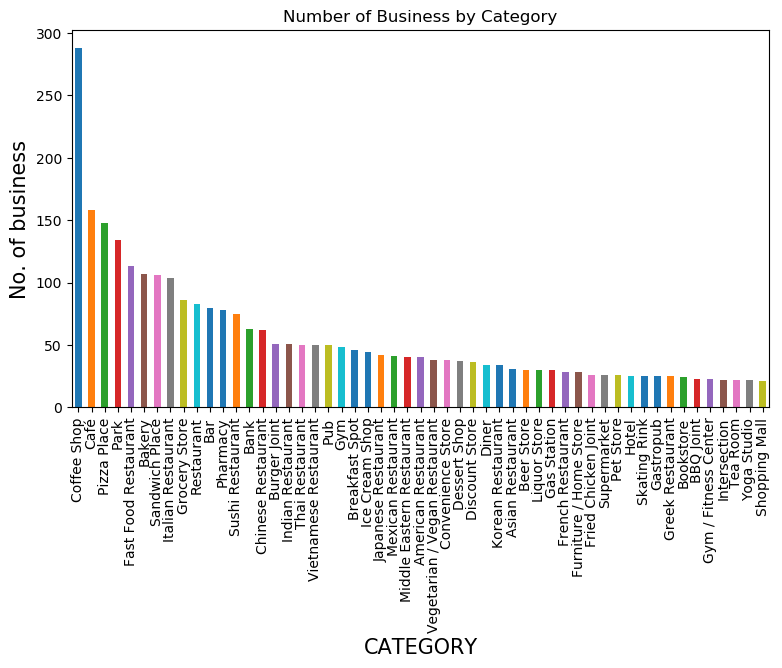

In [185]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Business by Category')
plt.xlabel('Category', fontsize = 15)
plt.ylabel('No. of business', fontsize=15)
df_venues_counts = df_venues.groupby('CATEGORY')['ID'].count()
df_venues_counts[df_venues_counts>20].sort_values(ascending=False).plot(kind='bar')
plt.show()

Let's get ratings of all Coffee Shop in neighborhoods.

In [156]:
df_coffe_shop = df_venues[df_venues['CATEGORY']=='Coffee Shop']
df_coffe_shop_details = pd.DataFrame(columns = ['ID', 'Name', 'Likes', 'Rating', 'Tips'])
#for id_coffe in df_coffe_shop.ID.values:
#    coffe_shop_details = get_venue_details(id_coffe)
#    coffe_shop_details = pd.concat([df_coffe_shop_details, coffe_shop_details], axis=0, ignore_index=True)

#{'meta': {'code': 429,
#  'errorType': 'quota_exceeded',
#  'errorDetail': 'Quota exceeded',
#  'requestId': '5e17047dc8cff2001b5796f9'},
# 'response': {}}

df_coffe_shop_details.columns = df_coffe_shop_details.columns.str.upper()
df_coffe_shop_details.head()

,ID,NAME,LIKES,RATING,TIPS


We will simulate the variables _LIKES, RATING, TIPS_, because the query quota was exceeded.

In [157]:
df_coffe_shop_details['ID'] = df_coffe_shop['ID']
df_coffe_shop_details['NAME'] = df_coffe_shop['NAME']
df_coffe_shop_details['LIKES'] = np.random.choice(50, df_coffe_shop.shape[0])
df_coffe_shop_details['RATING'] = np.random.uniform(0, 10, df_coffe_shop.shape[0])
df_coffe_shop_details['TIPS'] = np.random.choice(50, df_coffe_shop.shape[0])

df_coffe_shop_details.head()

,ID,NAME,LIKES,RATING,TIPS
9,4b78182cf964a52085b52ee3,Tim Hortons,0,6.709266,48
13,4c862910d8086dcba1939752,Tim Hortons,11,7.050684,21
37,51573fa5e4b0f0f5a84107b1,Tim Hortons,21,8.155157,32
54,50ad1433e4b065fd4f678ffd,Tim Hortons,16,3.073492,26
82,55d2781b498e82585d37691e,Creeds Coffee Bar,49,7.847720,10


The final data set for coffee shops is:

In [159]:
df_coffe_shop = df_coffe_shop.merge(df_coffe_shop_details.drop(['NAME'], axis=1), left_on='ID', right_on='ID')
df_coffe_shop.head()

,ID,NAME,CATEGORY,NEIGBORHOOD,LIKES,RATING,TIPS
0,4b78182cf964a52085b52ee3,Tim Hortons,Coffee Shop,Agincourt North,0,6.709266,48
1,4c862910d8086dcba1939752,Tim Hortons,Coffee Shop,Agincourt North,11,7.050684,21
2,51573fa5e4b0f0f5a84107b1,Tim Hortons,Coffee Shop,Agincourt South-Malvern West,21,8.155157,32
3,50ad1433e4b065fd4f678ffd,Tim Hortons,Coffee Shop,Alderwood,16,3.073492,26
4,55d2781b498e82585d37691e,Creeds Coffee Bar,Coffee Shop,Annex,49,7.847720,10


Now, we're going to get mean of _LIKES, RATING and TIPS_ by NEIGBORHOOD group.

In [164]:
df_coffe_shop_mean = df_coffe_shop[['NEIGBORHOOD', 'LIKES', 'RATING', 'TIPS']].groupby('NEIGBORHOOD').mean()
df_coffe_shop_mean.head()

,LIKES,RATING,TIPS
NEIGBORHOOD,,,
Agincourt North,5.5,6.879975,34.5
Agincourt South-Malvern West,21.0,8.155157,32.0
Alderwood,16.0,3.073492,26.0
Annex,26.0,5.932260,19.8
Banbury-Don Mills,17.0,4.661452,43.0


Before finishing data processing. We are going to pivot the *df_venues* data set by neighborhood. In addition, those venues with a frequency greater than 20 will be taken into account. Therefore, result data set is:

In [33]:
df_venues_counts_plus20 = df_venues_counts[df_venues_counts>20].index

df_venues_counts_neigh = df_venues.groupby(['NEIGBORHOOD', 'CATEGORY'])['ID'].count().reset_index()
df_venues_counts_neigh = df_venues_counts_neigh[df_venues_counts_neigh['CATEGORY'].isin(df_venues_counts_plus20)]
df_venues_counts_neigh
df_venues_counts_neigh = pd.pivot_table(df_venues_counts_neigh, values = 'ID', index=['NEIGBORHOOD'], columns = 'CATEGORY').fillna(0)
df_venues_counts_neigh.head()

CATEGORY,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beer Store,Bookstore,Breakfast Spot,Burger Joint,...,Sandwich Place,Shopping Mall,Skating Rink,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
NEIGBORHOOD,,,,,,,,,,,,,,,,,,,,,
Agincourt North,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Agincourt South-Malvern West,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Annex,2.0,0.0,1.0,4.0,0.0,2.0,0.0,3.0,0.0,1.0,...,1.0,0.0,0.0,0.0,2.0,2.0,1.0,4.0,1.0,0.0
Banbury-Don Mills,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we're going to merge *df_coffe_shop_mean* and *df_venues_counts_neigh* to *df_SocioDemo*. And final data set to clustering is:

In [49]:
df_Toronto = df_SocioDemo.merge(df_coffe_shop_mean, left_index=True, right_index=True)
df_Toronto = df_Toronto.merge(df_venues_counts_neigh, left_index=True, right_index=True)
df_Toronto.head()

,POPULATION_2016,POPULATION_DENSITY,YOUTH_PEOPLE,WORKING_PEOPLE,PRERETIREMENT_PEOPLE,MANAGEMENT_OCCUPATION,BUSINESS_OCCUPATION,HEALTH_OCCUPATION,EDUCATION_OCCUPATION,MANUFACTURING__OCCUPATION,...,Sandwich Place,Shopping Mall,Skating Rink,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
Agincourt North,29.113,3.929,3.705,11.305,4.230,960.000,2.425,740.000,950.000,1.350,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Agincourt South-Malvern West,23.757,3.034,3.360,9.965,3.265,960.000,2.170,655.000,865.000,1.015,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
Alderwood,12.054,2.435,1.235,5.220,1.825,840.000,1.150,295.000,735.000,350.000,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Annex,30.526,10.863,3.750,15.040,3.480,2.645,3.410,1.020,3.955,120.000,...,1.0,0.0,0.0,0.0,2.0,2.0,1.0,4.0,1.0,0.0
Banbury-Don Mills,27.695,2.775,2.730,10.810,3.555,2.120,2.870,1.145,1.875,165.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This concludes the data gathering phase. Now, we're now ready to use this data for analysis to produce the report on optimal locations for a new coffee shop. Thus, the neighborhoods for project will be shown on map.

In [83]:
#!pip install folium
import folium

address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lon in zip(df_Toronto.LATITUDE, df_Toronto.LONGITUDE):
    folium.Circle([lat, lon], radius=100, color='blue', fill=False).add_to(map_toronto)
    folium.Marker([lat, lon]).add_to(map_toronto)
    
map_toronto

## Methodology <a name="methodology"></a>

In this project we will try to detect a suitable location, in order to open a new business, in this case a new coffee shop in Toronto city at the same time similar to **Wychwood Park neighborhood**, because we suppose it an excellent business. For this, we will follow the next steps:

In first, We collect data required about each neighborhoods at Toronto. Information about socio-demographic, coordinates, number of business (coffee shops, bakeries, restaurants, etc), ratings, likes and tips mean for coffee shops by neighborhood. This information was obtained from **official pages** from Toronto, **Google page** and **Foursquare API**. [Data section](#data)

In second, We **merge all data** described above in unique data set with frequency of business greater than 20 to avoid low values, sociodemographic information and ratings, likes and tips mean for coffee shops by neighborhood. And then, we show some statistical and plots for each column.

In third, for clustering analysis we will **standardize** data by dividing each column for the population of each neighborhood, except for population density.

In fourth, we cluster data with the **optimal number of clusters** using **elbow method**, testing with different numbers of groups.

In fifth, with clustered data, we select the **suitable neighborhood** for our new coffee shop using frequency of coffee shop and rating.

Finally, we present results, Discussion and conclusion.

## Analysis <a name="analysis"></a>

We're going to show statistical table for Toronto data set, excluding *LATITUDE* and *LONGITUDE*.

In [85]:
df_Toronto_for_cluster = df_Toronto.drop(['LATITUDE', 'LONGITUDE'], axis=1)
df_Toronto_for_cluster.describe()

,POPULATION_2016,POPULATION_DENSITY,YOUTH_PEOPLE,WORKING_PEOPLE,PRERETIREMENT_PEOPLE,MANAGEMENT_OCCUPATION,BUSINESS_OCCUPATION,HEALTH_OCCUPATION,EDUCATION_OCCUPATION,MANUFACTURING__OCCUPATION,...,Sandwich Place,Shopping Mall,Skating Rink,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
count,82.000000,82.00000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,...,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,19.306000,6.32322,36.495244,8.569878,10.296951,343.818415,123.469390,468.533963,310.153659,264.602073,...,1.207317,0.231707,0.292683,0.280488,0.902439,0.256098,0.609756,0.463415,0.548780,0.268293
std,8.710025,3.75520,175.564397,4.048433,71.523426,364.293723,298.036739,246.894042,393.252397,229.404120,...,1.015167,0.504273,0.577089,0.503675,1.301564,0.604734,0.885495,1.146063,1.166957,0.588968
min,7.607000,1.57000,1.040000,3.245000,1.100000,1.020000,1.015000,1.020000,1.050000,1.015000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.002750,3.72750,1.511250,5.860000,1.596250,1.413750,1.383750,295.000000,1.415000,95.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16.935000,5.41850,2.180000,7.850000,2.145000,310.000000,1.840000,457.500000,2.220000,200.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23.901500,7.46950,3.217500,10.636250,3.117500,697.500000,2.610000,643.750000,742.500000,390.000000,...,2.000000,0.000000,0.000000,0.750000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,53.485000,23.04400,960.000000,25.850000,650.000000,985.000000,965.000000,970.000000,995.000000,930.000000,...,5.000000,2.000000,2.000000,2.000000,5.000000,3.000000,4.000000,7.000000,6.000000,3.000000


We show the corresponding histogram charts for each column.

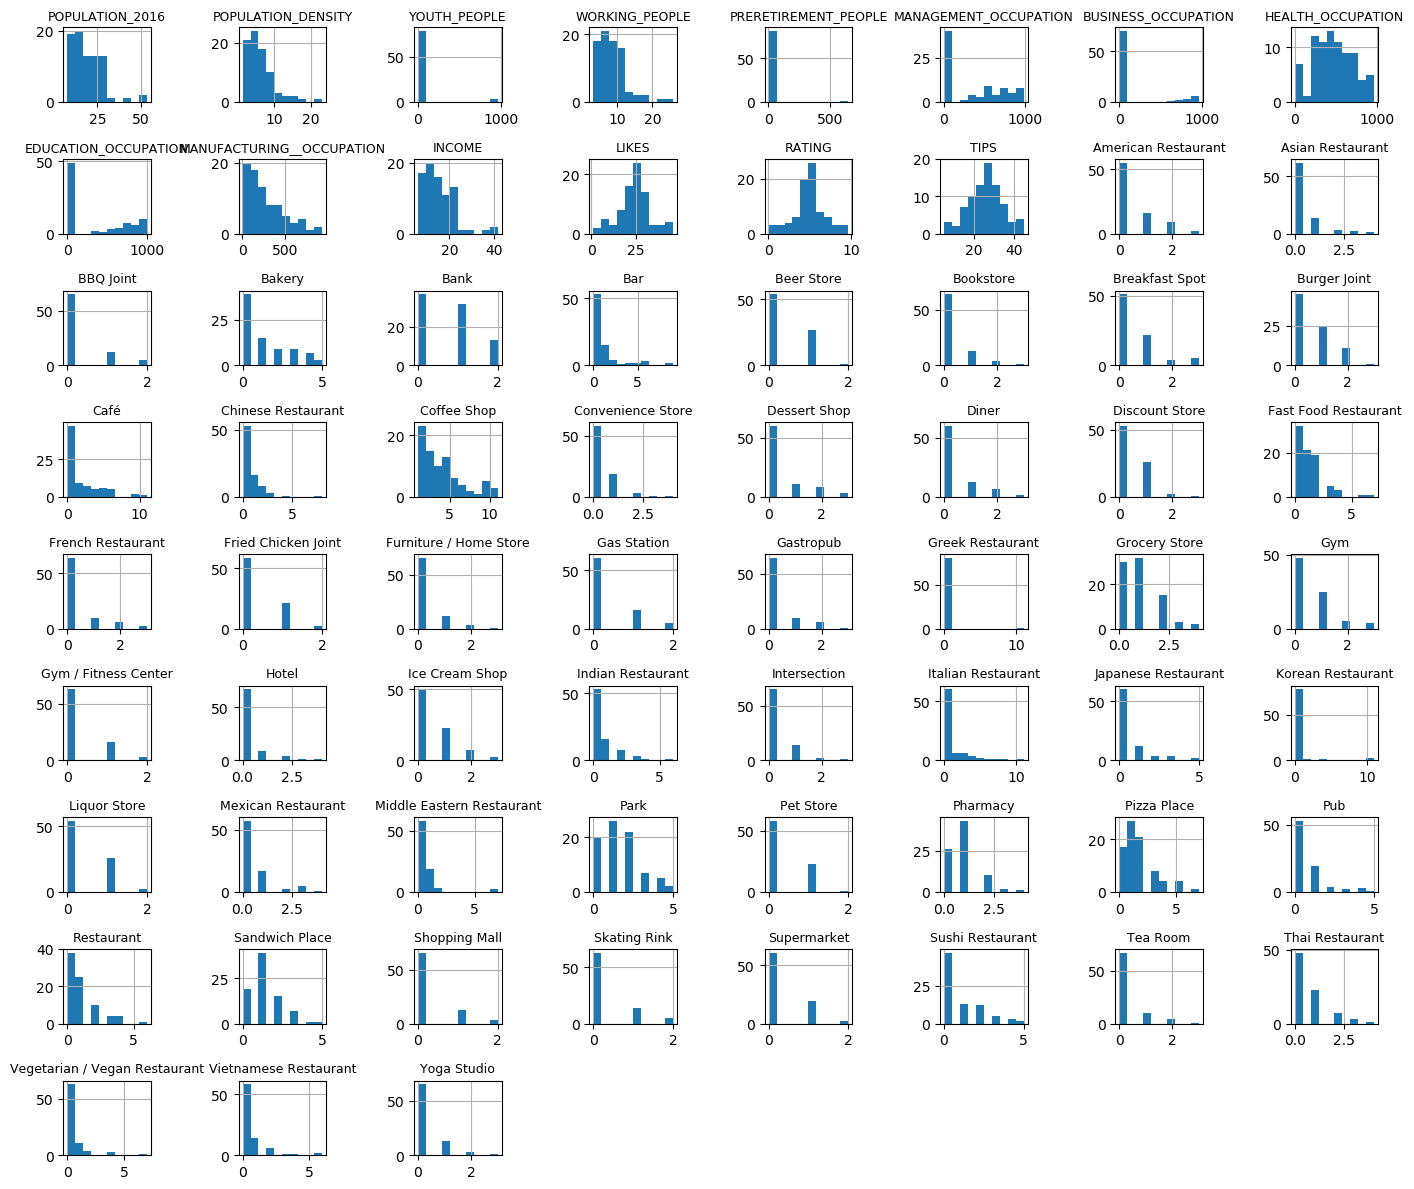

In [114]:
import matplotlib.pyplot as plt

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(14, 12), dpi = 100)
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name, fontsize=9)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(df_Toronto_for_cluster, df_Toronto_for_cluster.columns, 9, 8)

Now, we standardize the data set using the column *'POPULATION_2016*.

In [120]:
df_Toronto_for_cluster = df_Toronto_for_cluster.iloc[:,1:].div(df_Toronto_for_cluster['POPULATION_2016'], axis=0)
df_Toronto_for_cluster.head()

,POPULATION_DENSITY,YOUTH_PEOPLE,WORKING_PEOPLE,PRERETIREMENT_PEOPLE,MANAGEMENT_OCCUPATION,BUSINESS_OCCUPATION,HEALTH_OCCUPATION,EDUCATION_OCCUPATION,MANUFACTURING__OCCUPATION,INCOME,...,Sandwich Place,Shopping Mall,Skating Rink,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
Agincourt North,0.134957,0.127263,0.388314,0.145296,32.974960,0.083296,25.418198,32.631470,0.046371,0.807371,...,0.034349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034349,0.0
Agincourt South-Malvern West,0.127710,0.141432,0.419455,0.137433,40.409143,0.091341,27.570821,36.410321,0.042724,0.815339,...,0.042093,0.042093,0.042093,0.042093,0.042093,0.000000,0.000000,0.000000,0.042093,0.0
Alderwood,0.202008,0.102456,0.433051,0.151402,69.686411,0.095404,24.473204,60.975610,29.036005,0.822549,...,0.082960,0.082960,0.082960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Annex,0.355861,0.122846,0.492695,0.114001,0.086647,0.111708,0.033414,0.129562,3.931075,0.839121,...,0.032759,0.000000,0.000000,0.000000,0.065518,0.065518,0.032759,0.131036,0.032759,0.0
Banbury-Don Mills,0.100199,0.098574,0.390323,0.128363,0.076548,0.103629,0.041343,0.067702,5.957754,0.806463,...,0.036108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Once we have the database we proceed to make similar groups and see in group the initially selected neighborhood falls. We will do this with the *k-means algorithm*. Once we form the groups and when we know the group that is in our neighborhood, the neighborhoods that are within that group are *potential places* where we can locate our new business

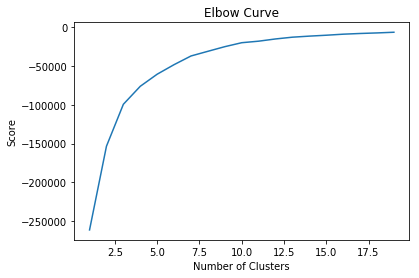

In [123]:
from sklearn.cluster import KMeans

X = df_Toronto_for_cluster.values
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The KElbowVisualizer implements the **elbow method** to help data scientists select the **optimal number of clusters** by fitting the model with a range of values for K. If the line chart resembles an arm, then the "elbow" (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visualizer “elbow” will be annotated with a dashed line.

In this case it is indicating that the **optimal number** of groups is **5**, since at this point the curve dramatically changes its direction.

Now, we cluster with 5 groups. Then, we predict and add the final table to *df Toronto*. Then, we show a header.

In [151]:
kmeans = KMeans(n_clusters=5)
df_Toronto['CLUSTER'] = kmeans.fit(X).predict(X)
df_Toronto.head()

,POPULATION_2016,POPULATION_DENSITY,YOUTH_PEOPLE,WORKING_PEOPLE,PRERETIREMENT_PEOPLE,MANAGEMENT_OCCUPATION,BUSINESS_OCCUPATION,HEALTH_OCCUPATION,EDUCATION_OCCUPATION,MANUFACTURING__OCCUPATION,...,Shopping Mall,Skating Rink,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio,CLUSTER
Agincourt North,29.113,3.929,3.705,11.305,4.230,960.000,2.425,740.000,950.000,1.350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
Agincourt South-Malvern West,23.757,3.034,3.360,9.965,3.265,960.000,2.170,655.000,865.000,1.015,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
Alderwood,12.054,2.435,1.235,5.220,1.825,840.000,1.150,295.000,735.000,350.000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Annex,30.526,10.863,3.750,15.040,3.480,2.645,3.410,1.020,3.955,120.000,...,0.0,0.0,0.0,2.0,2.0,1.0,4.0,1.0,0.0,1
Banbury-Don Mills,27.695,2.775,2.730,10.810,3.555,2.120,2.870,1.145,1.875,165.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Now, we count number of neighborhood in each cluster.

In [154]:
df_Toronto['CLUSTER'].to_frame().reset_index().groupby('CLUSTER').count()

,index
CLUSTER,
0,20
1,39
2,3
3,9
4,11


In [169]:
Opt_cluster = df_Toronto[df_Toronto.index=='Wychwood']['CLUSTER'].iloc[0]

print('Coffee shop at Wychwood is located in cluster {}. \nSo, we have to find the optimal location beetween neighborhoods within this cluster.'.format(Opt_cluster))

Coffee shop at Wychwood is located in cluster 1. 
So, we have to find the optimal location beetween neighborhoods within this cluster.


Important data inside cluster 1 sorted by rating is:

In [177]:
df_Toronto[['POPULATION_2016', 'POPULATION_DENSITY', 'LATITUDE', 'LONGITUDE', 'LIKES', 'Coffee Shop', 'RATING', 'TIPS', 'CLUSTER']]\
    [df_Toronto['CLUSTER']==1].sort_values(by='RATING', ascending=True)

,POPULATION_2016,POPULATION_DENSITY,LATITUDE,LONGITUDE,LIKES,Coffee Shop,RATING,TIPS,CLUSTER
Glenfield-Jane Heights,30.491,5.864,47.540336,-52.842015,45.000000,1.0,0.065178,15.000000,1
Rosedale-Moore Park,20.923,4.500,43.690388,-79.383297,23.428571,5.0,1.605968,26.428571,1
Bendale,29.960,4.011,43.753520,-79.255336,38.000000,1.0,2.123747,26.000000,1
Woburn,53.485,4.345,43.759824,-79.225291,31.500000,2.0,2.385849,18.500000,1
O'Connor-Parkview,18.675,3.780,43.705537,-79.312718,13.000000,1.0,2.787105,5.000000,1
Leaside-Bennington,16.828,3.596,43.702062,-79.378044,24.500000,5.0,3.170992,19.000000,1
Stonegate-Queensway,25.051,3.199,43.621950,-79.523499,22.000000,4.0,3.212015,23.000000,1
Moss Park,20.506,14.753,43.654644,-79.369728,27.300000,9.0,3.996222,21.000000,1
Bayview Village,21.396,4.195,43.769197,-79.376662,22.500000,4.0,4.002400,29.250000,1
Little Portugal,15.559,12.859,43.647413,-79.431116,18.000000,4.0,4.066465,35.000000,1


In [179]:
df_cluster1 = df_Toronto[['POPULATION_2016', 'POPULATION_DENSITY', 'LATITUDE', 'LONGITUDE', 'LIKES', 'Coffee Shop', 'RATING', 'TIPS', 'CLUSTER']]\
    [df_Toronto['CLUSTER']==1]
df_cluster1.describe()

,POPULATION_2016,POPULATION_DENSITY,LATITUDE,LONGITUDE,LIKES,Coffee Shop,RATING,TIPS,CLUSTER
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.0
mean,23.148923,7.174359,43.799907,-78.698773,24.758817,4.512821,4.841883,24.280167,1.0
std,9.782530,4.109420,0.616625,4.249827,8.251248,2.845789,1.642675,7.086892,0.0
min,10.732000,2.724000,43.621950,-79.523499,7.000000,1.000000,0.065178,5.000000,1.0
25%,16.057500,4.362500,43.665470,-79.413892,20.439394,2.500000,4.169257,20.125000,1.0
50%,21.396000,5.864000,43.686433,-79.387395,24.500000,4.000000,5.001478,24.000000,1.0
75%,27.570500,9.540500,43.751221,-79.322967,29.194444,6.000000,5.736806,28.000000,1.0
max,53.485000,23.044000,47.540336,-52.842015,45.000000,11.000000,8.661944,43.000000,1.0


This concludes our analysis. We found 38 places similar to **Wychwood** (excluding Wychwood) that may be possible places to locate a new coffee shop. The **Glenfield-Jane Heights neighborhood** will be selected, because it has an average cafeteria score lower than all (a coffee shop with better features will ensure business's success). In addition, it has a population above average.

## Results and Discussion <a name="results"></a>

Our analysis reported 38 potential places to open a new coffe shop. This was done by collecting information from various sources to obtain a better result and use clustering algorithms such as k-means to group neighborhoods with similar characteristics.

Selection of the best neighborhood within cluster 1 was chosen based on the rating. In this case, one with the lowest value, because, by locating a coffee shop in this neighborhood, it is guaranteed to capture a large part of the dissatisfied consumers, which will generate greater profits for the brand.

This project can generate greater value if information about time series of profitability would be available, With this, it could also predict the possible profitability that would be obtained by locating the new coffee shop in that place.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify similar neighborhoods to Wychwood, in order to locate a new coffee shop in optimal location. Using information of different types and advanced clustering techniques. It is concluded that the best place to locate a new coffee shop is **Glenfield-Jane Heights** neighborhood.